In [1]:
import os
import glob

import pandas as pd
from pyteomics import mzml  # Library used to open mzml format files (spectra format)

from spectrum import Spectrum

### Metadata in the DB

In [2]:
substances_dict = {'CH3NO2': {'cas': '75-62-5',
                       'substance name': 'Nitromethane',
                       'other names': 'Methane, nitro',
                       'molecular formula': 'CH3NO2',
                       'monoisotopic mass': 61.016376},
            'CHCl3': {'cas': '67-66-3',
                      'substance name': 'Chloroform',
                      'other names': 'methane trichloride, methane, trichloro-',
                      'molecular formula': 'CHCl3',
                      'monoisotopic mass': 117.914383},
            'CycloHexane': {'cas': '110-82-7',
                            'substance name': 'Cyclohexane',
                            'other names': '-',
                            'molecular formula': 'C6H12',
                            'monoisotopic mass': 84.093903},
            'Hexane': {'cas': '110-54-3',
                       'substance name': 'Hexane',
                       'other names': 'n-hexane',
                       'molecular formula': 'C6H14',
                       'monoisotopic mass': 86.10955}}

### Loading spectra measured on the Trap

In [3]:
mzml_files = glob.glob('data/database_trap/*.mzml')  # List of all mzXML files in the data/database_trap

trap_db = []
step = .1  # sampling step
threshold = 0.05

for i, file_path in enumerate(mzml_files):  # Go through each file
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    ms_data = mzml.read(file_path)
    spectrum = list(ms_data)[0]
    
    print(f'Обнаружен файл формата .mzml: {file_path}')

    mz = spectrum.pop('m/z array')
    intensities = spectrum.pop('intensity array')
    substance_name = substances_dict[file_name]['substance name']

    # Create a Spectrum object
    metadata = {
        'id': i+1,
        'file name': file_name,
        'cas': substances_dict[file_name]['cas'],
        'other names': substances_dict[file_name]['other names'],
        'molecular formula': substances_dict[file_name]['molecular formula'],
        'monoisotopic mass': substances_dict[file_name]['monoisotopic mass']
    }

    spectrum = Spectrum(mz, intensities, substance_name, **metadata)
    
    spectrum.resample(step) # Changing the sampling step
    spectrum.normalize()  # Min-max normalization
    spectrum.apply_threshold(threshold) # Cutting off values below the threshold
    
    trap_db.append(spectrum)

print("An example of a spectrum with metadata obtained on the Trap:")
print(vars(trap_db[0]))

Обнаружен файл формата .mzml: data/database_trap\CH3NO2.mzml
Обнаружен файл формата .mzml: data/database_trap\CHCl3.mzml
Обнаружен файл формата .mzml: data/database_trap\CycloHexane.mzml
Обнаружен файл формата .mzml: data/database_trap\Hexane.mzml
An example of a spectrum with metadata obtained on the Trap:
{'mz': array([  3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,   3.7,   3.8,
         3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,   4.6,   4.7,
         4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,   5.5,   5.6,
         5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,   6.4,   6.5,
         6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,   7.3,   7.4,
         7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,   8.2,   8.3,
         8.4,   8.5,   8.6,   8.7,   8.8,   8.9,   9. ,   9.1,   9.2,
         9.3,   9.4,   9.5,   9.6,   9.7,   9.8,   9.9,  10. ,  10.1,
        10.2,  10.3,  10.4,  10.5,  10.6,  10.7,  10.8,  10.9,  11. ,
        11.1,  11.2,  11.3,  11.4,  11.5,  11.6,  11.7

###  Forming the DB

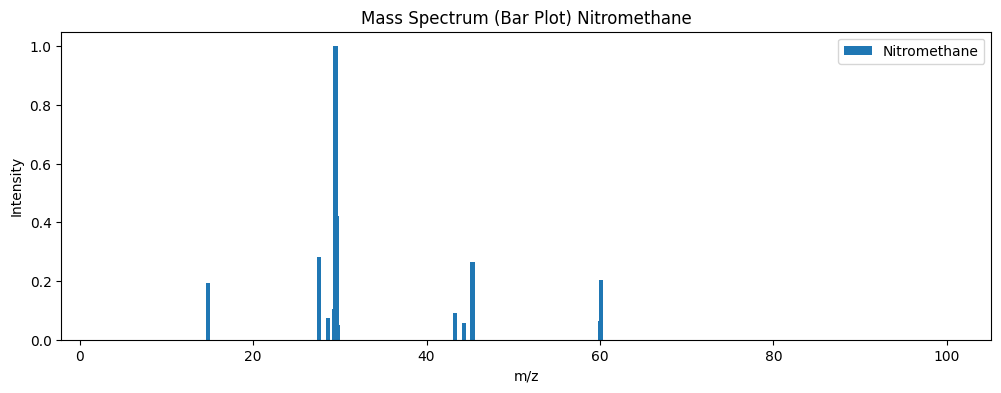

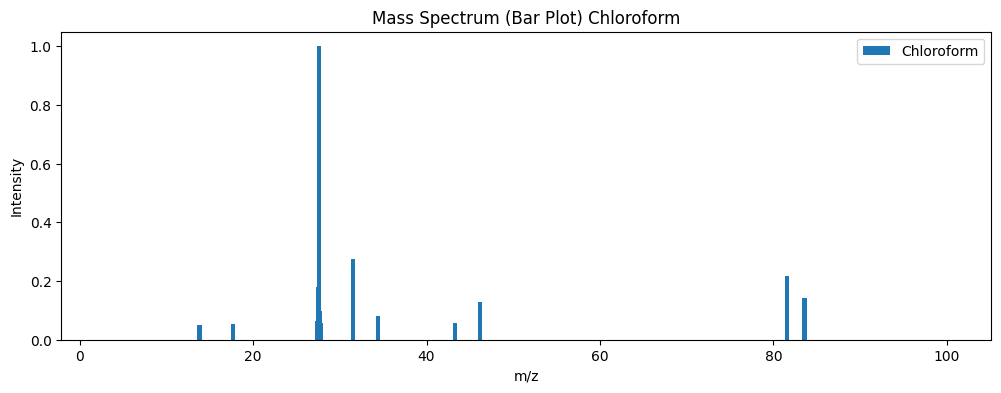

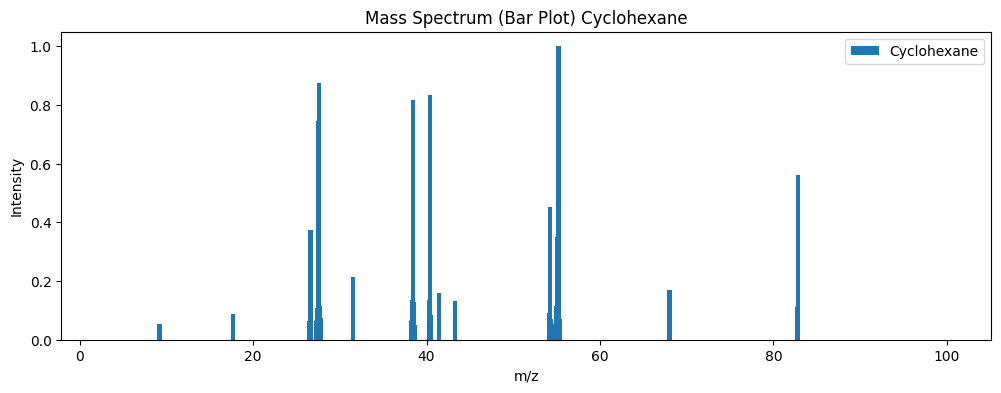

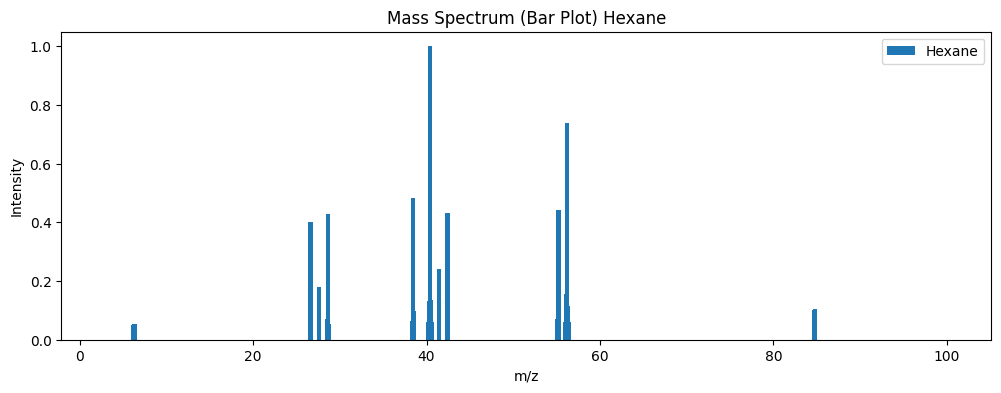

In [4]:
results_path = 'results/database_trap'

for spectrum in trap_db:

    spectrum.barplot()

    with open(f'{results_path}/{spectrum.metadata["file name"]}.txt', 'w') as f:
        f.write(f'id: {spectrum.metadata["id"]}\n' +
                f'substance name: {spectrum.substance_name}\n' +
                f'file name: {spectrum.metadata["file name"]}\n' +
                f'CAS: {spectrum.metadata["cas"]}\n' +
                f'other names: {spectrum.metadata["other names"]}\n' +
                f'molecular formula: {spectrum.metadata["molecular formula"]}\n' +
                f'monoisotopic mass: {spectrum.metadata["monoisotopic mass"]}\n' +
                f'array length: {len(spectrum.mz)}\n' +
                f'mz: {list(spectrum.mz)}\n' +
                f'intensities: {list(spectrum.intensities)}') 

### Build the database in .xlsx

In [5]:
file_list = os.listdir(results_path)  # A list of all the files in the folder

db = []

for file in file_list:
    if file.endswith('.txt'):
        file_path = os.path.join(results_path, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            file_data = {}
            for line in lines:
                key, value = line.strip().split(': ')
                if key in ['mz', 'intensities']:
                    value = [float(v) for v in value[1:-1].split(', ')]
                file_data[key] = value
            db.append(file_data)

df = pd.DataFrame(db)
df['id'] = df['id'].astype('int')
df = df.sort_values('id').reset_index(drop=True)
df.to_excel(f'{results_path}/database_trap.xlsx', index=False)  # Saving to Excel